<a href="https://colab.research.google.com/github/MegalaJ29/LGMVIP/blob/main/Task2_Stock_Market_Prediction_And_Forecasting_Using_Stacked_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TASK 2**
**Stock Market Prediction And Forecasting Using Stacked LSTM**

**ABOUT THE PROJECT**

Trying to predict how the securities exchange will work is one of the most difficult tasks. There are so many variables involved with the expectation – physical elements versus psychological factors, rational and irrational behaviour, and so on. All of these factors combine to make share costs unpredictable and difficult to predict with any degree of certainty.

Data can be found at https://raw.githubusercontent.com/mwitiderrick/stockprice/master/NSE-TATAGLOBAL.csv

In [1]:
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Uploading required file

In [2]:
from google.colab import files
uploaded=files.upload()

Saving NSE-TATAGLOBAL.csv to NSE-TATAGLOBAL.csv


In [3]:
import pandas as pd

In [4]:
df = pd.read_csv('/content/NSE-TATAGLOBAL.csv')
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


In [5]:
df.tail()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
2030,2010-07-27,117.6,119.50,112.00,118.80,118.65,586100,694.98
2031,2010-07-26,120.1,121.00,117.10,117.10,117.60,658440,780.01
2032,2010-07-23,121.8,121.95,120.25,120.35,120.65,281312,340.31
2033,2010-07-22,120.3,122.00,120.25,120.75,120.90,293312,355.17
2034,2010-07-21,122.1,123.00,121.05,121.10,121.55,658666,803.56


In [6]:
# To display stats about data
df.describe()

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
count,2035.000000,2035.000000,2035.000000,2035.000000,2035.00000,2.035000e+03,2035.000000
mean,149.713735,151.992826,147.293931,149.474251,149.45027,2.335681e+06,3899.980565
std,48.664509,49.413109,47.931958,48.732570,48.71204,2.091778e+06,4570.767877
min,81.100000,82.800000,80.000000,81.000000,80.95000,3.961000e+04,37.040000
25%,120.025000,122.100000,118.300000,120.075000,120.05000,1.146444e+06,1427.460000
50%,141.500000,143.400000,139.600000,141.100000,141.25000,1.783456e+06,2512.030000
75%,157.175000,159.400000,155.150000,156.925000,156.90000,2.813594e+06,4539.015000
max,327.700000,328.750000,321.650000,325.950000,325.75000,2.919102e+07,55755.080000


In [7]:
# Check for null values
df.isnull().sum()

Date                    0
Open                    0
High                    0
Low                     0
Last                    0
Close                   0
Total Trade Quantity    0
Turnover (Lacs)         0
dtype: int64

In [8]:
# To basic info about datatype
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2035 entries, 0 to 2034
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  2035 non-null   object 
 1   Open                  2035 non-null   float64
 2   High                  2035 non-null   float64
 3   Low                   2035 non-null   float64
 4   Last                  2035 non-null   float64
 5   Close                 2035 non-null   float64
 6   Total Trade Quantity  2035 non-null   int64  
 7   Turnover (Lacs)       2035 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 127.3+ KB


In [9]:
# To display no. of samples on each class
df_close=df.reset_index()['Close']
df_close

0       233.75
1       233.25
2       234.25
3       236.10
4       233.30
         ...  
2030    118.65
2031    117.60
2032    120.65
2033    120.90
2034    121.55
Name: Close, Length: 2035, dtype: float64

In [10]:
import matplotlib.pyplot as plt

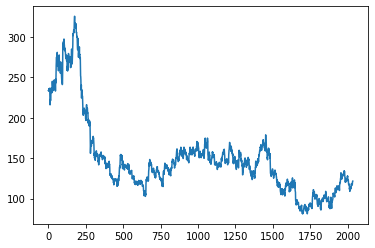

In [11]:
plt.plot(df_close)

In [12]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [13]:
scaler=MinMaxScaler(feature_range=(0,1))
df1_close=scaler.fit_transform(np.array(df_close).reshape(-1,1))
print(df1_close)

[[0.62418301]
 [0.62214052]
 [0.62622549]
 ...
 [0.1621732 ]
 [0.16319444]
 [0.16584967]]


**Train and Test Split**

Whenever training Timeseries data we should divide the data differently we should train the data with the respective date.

Always remember that in time-series data the one data is dependent on other data. The training size should be 65% of the total length of the data frame, the test size should be the difference between the length of the dataset and the training size.

In [14]:
#splitting dataset into train and test split
training_size=int(len(df1_close)*0.65)
test_size=len(df1_close)-training_size
train_data,test_data=df1_close[0:training_size,:],df1_close[training_size:len(df1_close),:1]

Train and Test ready

In [15]:
training_size,test_size

(1322, 713)

In [16]:
train_data

array([[0.62418301],
       [0.62214052],
       [0.62622549],
       ...,
       [0.25347222],
       [0.26041667],
       [0.2563317 ]])

**Data Preprocessing**

Now consider the time steps, if I want to predict the price of the stock in a day that how previous data should be considered.

Now the timestep value will be 100. Let’s split the data X, Y. In the 0th iteration the first 100 elements goes as your first record and the 101 elements will be put up in the X. The 100 elements will be put up in the Y.

In [17]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   #i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [18]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [19]:
print(X_train.shape), print(y_train.shape)

(1221, 100)
(1221,)


(None, None)

In [20]:
print(X_test.shape), print(ytest.shape)

(612, 100)
(612,)


(None, None)

**LSTM**

LSTMs are widely used for sequence prediction problems and have proven to be extremely effective. The reason they work so well is that LSTM can store past important information and forget the information that is not.

LSTM has *three* gates:

**The input gate:** The input gate adds information to the cell state,

**The forget gate:** It removes the information that is no longer required by the model,

**The output gate:** Output Gate at LSTM selects the information to be shown as output.

While Implementing any LSTM, we should always reshape our X train in 3-D, add 1 the reason behind is the time step and the 1 is given to the LSTM.

In [21]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

importing module for stacked LSTM

In [22]:
# Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [23]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

Summary below:

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


Now the final part is to fit the X_train and the y_train.

In [25]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
20/20 [==============================] - 11s 262ms/step - loss: 0.0280 - val_loss: 0.0088
Epoch 2/100
20/20 [==============================] - 4s 198ms/step - loss: 0.0036 - val_loss: 0.0018
Epoch 3/100
20/20 [==============================] - 4s 198ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 4/100
20/20 [==============================] - 4s 195ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 5/100
20/20 [==============================] - 4s 195ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 6/100
20/20 [==============================] - 4s 197ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 7/100
20/20 [==============================] - 4s 196ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 8/100
20/20 [==============================] - 4s 197ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 9/100
20/20 [==============================] - 4s 198ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 10/100
20/20 [==============================] - 4s 197ms/step - loss: 0.0012 - val_l

In [26]:
import tensorflow as tf

**Prediction**

Predict both the X_train and the X_test, now let’s scaler inverse transform because I want to see the root mean square performance.

In [27]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [28]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

167.04026260998927

In [29]:
math.sqrt(mean_squared_error(ytest,test_predict))

116.30403229896635

Plotting

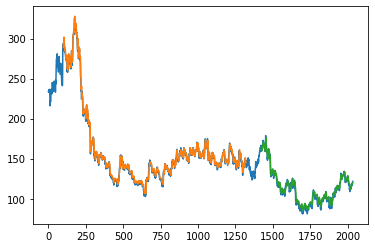

In [30]:
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1_close)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1_close)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1_close)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1_close))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

Here the time step is 100, Whatever the values in train predict and test predict.Don’t forget to plot the inverse of scaler transform.

Green indicates the Predicted Data

Blue indicates the Complete Data

Orange indicates the Train Data

**Predicting Stock Rate for next 30 days**

In [31]:
len(test_data)

713

In [32]:
x_input=test_data[613:].reshape(1,-1)
x_input.shape

(1, 100)

In [33]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [34]:
temp_input

[0.12479575163398693,
 0.1384803921568627,
 0.14011437908496732,
 0.1388888888888889,
 0.13541666666666663,
 0.14011437908496732,
 0.13807189542483655,
 0.130718954248366,
 0.130718954248366,
 0.12867647058823528,
 0.11846405228758167,
 0.14644607843137253,
 0.1480800653594771,
 0.159109477124183,
 0.15992647058823523,
 0.1578839869281045,
 0.16441993464052285,
 0.178921568627451,
 0.17933006535947704,
 0.19260620915032678,
 0.2081290849673203,
 0.18974673202614378,
 0.18055555555555558,
 0.1823937908496731,
 0.17708333333333326,
 0.17810457516339862,
 0.18055555555555558,
 0.17810457516339862,
 0.17851307189542487,
 0.196078431372549,
 0.18913398692810457,
 0.1895424836601307,
 0.19403594771241828,
 0.19444444444444442,
 0.20200163398692816,
 0.19771241830065356,
 0.19934640522875813,
 0.19873366013071891,
 0.19975490196078427,
 0.21282679738562094,
 0.21568627450980393,
 0.2044526143790849,
 0.21772875816993464,
 0.21098856209150318,
 0.21425653594771243,
 0.1975081699346406,
 0.1881

In [35]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
nextNumberOfDays=30
i=0

while(i<nextNumberOfDays):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.16750532]
101
1 day input [0.13848039 0.14011438 0.13888889 0.13541667 0.14011438 0.1380719
 0.13071895 0.13071895 0.12867647 0.11846405 0.14644608 0.14808007
 0.15910948 0.15992647 0.15788399 0.16441993 0.17892157 0.17933007
 0.19260621 0.20812908 0.18974673 0.18055556 0.18239379 0.17708333
 0.17810458 0.18055556 0.17810458 0.17851307 0.19607843 0.18913399
 0.18954248 0.19403595 0.19444444 0.20200163 0.19771242 0.19934641
 0.19873366 0.1997549  0.2128268  0.21568627 0.20445261 0.21772876
 0.21098856 0.21425654 0.19750817 0.18811275 0.17851307 0.17381536
 0.16033497 0.16564542 0.17116013 0.17422386 0.18035131 0.17401961
 0.16278595 0.16973039 0.17810458 0.17034314 0.16830065 0.17279412
 0.17544935 0.18382353 0.19138072 0.18913399 0.19097222 0.17238562
 0.16830065 0.1693219  0.17177288 0.16156046 0.14971405 0.1503268
 0.15196078 0.14726307 0.14501634 0.14603758 0.12479575 0.13112745
 0.11397059 0.1190768  0.12377451 0.13562092 0.12908497 0.13459967
 0.12806373 0.13031046 0.12724673 0

In [36]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [37]:
import matplotlib.pyplot as plt

In [38]:
len(df1_close)

2035

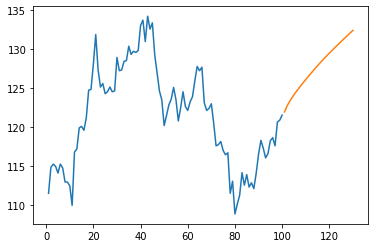

In [39]:
plt.plot(day_new,scaler.inverse_transform(df1_close[1935:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

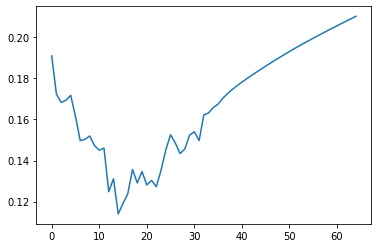

In [40]:
df3=df1_close.tolist()
df3.extend(lst_output)
plt.plot(df3[2000:])

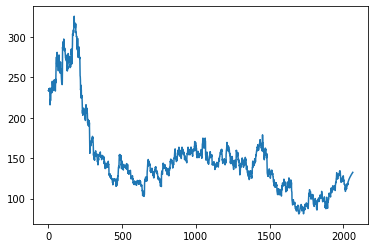

In [41]:
df3=scaler.inverse_transform(df3).tolist()
plt.plot(df3)

Hence Stock Market Prediction And Forecasting Using Stacked LSTM is completed.

# **Task 2 completed**